In [26]:
# En primer lugar, debemos importar los paquetes necesarios para la visualización
# Este paso se explicará en otro cuaderno, no es necesario prestarle atención por ahora
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

# Función de activación lineal sencilla: solo devuelve la identidad


def linear(z):
    return z


def single_neuron_regression_model(W, w_0, X):

    # Ejecutar el producto escalar del input x y los pesos aprendidos w
    z = np.dot(X, W.T) + w_0

    # Aplicar la función de activación y devolver
    a = linear(z)
    return a

# Hemos escrito la función de regresión de una sola neurona
# sin dar por hecho el número de dimensiones de los datos de input,
# (es decir, puede haber 1 atributo x, 10 o cualquier número). Esto es fundamental
# para que el modelo pueda aprender con un conjunto de datos que tenga un vector de cualquier número de dimensiones x


In [45]:
# Test: output del modelo para un único punto de datos en 2D
x = np.array([1, 2])
w = np.array([5, 3])
w_0 = -8

y = single_neuron_regression_model(w, w_0, x)
print("input", x, "=> output", y)

input [1 2] => output 3


## Entrenar un modelo de regresión - Descenso de gradiente

Función de coste $J$, donde $J$ es la *pérdida* total $L$ en todo el conjunto de entrenamiento:

$$ J = \sum_i^n L(\hat{y}^{(i)}, y^{(i)})$$ 

Empezaremos con una función de pérdida relativamente simple, adecuada para un problema de regresión: vamos a utilizar la pérdida del error cuadrático (EC), donde $\epsilon^{(i)}$ es el error para cualquier muestra $i$ dada:

$$ L_{SE}(\hat{y}^{(i)}, y^{(i)}) = \frac{1}{2} (\hat{y_i} - y_i)^2 = \frac{1}{2} \epsilon^2 $$

El proceso de entrenamiento es el siguiente:
* Se completa el bucle de entrenamiento para un número especificado de iteraciones en todo el conjunto de datos (lo que también se conoce como ciclos)
* En cada ciclo, observa todos los pares de *input* y *output* $(x^{(i)},y^{(i)})$. Para cada uno:

  * Se calcula la pérdida $L$ entre el valor correcto $y$ y el valor predicho $\hat{y}$
  * Se calcula el gradiente de la pérdida con respecto a cada peso
  * Se actualizan los pesos en función del gradiente y la tasa de aprendizaje, $\eta$:
  
$$ w_{j,new} = w_j - \eta \frac{dJ}{dw_j}$$

### Descenso de gradiente con pérdida del error cuadrático (EC)

En el caso de la pérdida del error cuadrático, para cualquier punto de datos $i$, este es el proceso:

$$ \frac{dJ}{dw_j} = \frac{dL_{SE}}{dw_j}  
  = \frac{dL_{SE}}{d\hat{y}} \frac{d\hat{y}}{dw_j} 
  = (\hat{y} - y) \frac{d\hat{y}}{dw_j} $$

Vemos que es necesario poder calcular el gradiente del *output* del modelo respecto a cada peso:

$$ \frac{d\hat{y}}{dw_j} = \frac{df(z)}{dz} \frac{dz}{dw_j} $$

Para la función de activación lineal $f(z) = z$, el primer término es muy simple: $\frac{df(z)}{dz} = 1$.

Para el segundo, recordemos que:

$$ z = w_0 + x_1 \cdot w_1 + \cdots + x_j \cdot w_j + \dots + x_m \cdot w_m $$

Entonces $\frac{dz}{dw_j} = x_j$, excepto para $w_0$, donde $\frac{dz}{dw_0} = 1.$ 

### Implementación del descenso de gradiente -- Pérdida del error cuadrático

In [46]:
# Ahora, definamos la función de entrenamiento para el caso de la pérdida del error cuadrático.
# De nuevo, queremos que funcione independientemente de las dimensiones de los datos de input
# y que sea lo bastante flexible para trabajar con funciones de diferentes modelos
def train_model_SE_loss(model_function, w, w_0,
						input_data, output_data,
						learning_rate, num_epochs):
	do_print = False
	for epoch in range(num_epochs):
		total_loss = 0  # Hacer un seguimiento de la pérdida total en todo el conjunto de datos
		for x, y in zip(input_data, output_data):
			y_predicted = model_function(w, w_0, x)
			error = y_predicted - y
			total_loss += (error**2)/2
			if do_print:
				print("x:", x, "y:", y, "error:", error)
			if do_print:
				print(" old weights:", w, w_0)

			# Actualizar el coeficiente de sesgo utilizando el gradiente respecto a w_0
			w_0 -= learning_rate * error * 1

			# Actualizar otros coeficientes del modelos utilizando el gradiente respecto a cada coeficiente
			for j, x_j in enumerate(x):
				w[j] -= learning_rate * error * x_j
			if do_print:
				print(" new weights:", w, w_0)

		report_every = max(1, num_epochs // 10)
		if epoch % report_every == 0:  # Cada pocos ciclos, generar un informe del progreso
			print("epoch", epoch, "has total loss", total_loss)

	return w, w_0


In [47]:
# Utilizaremos esta función para evaluar el rendimiento
# de nuestro modelo de regresión entrenado. Calculará el error cuadrático medio de los datos
def evaluate_regression_accuracy(model_function, w, w_0, input_data, output_data):
    total_loss = 0
    n = len(input_data)
    for x, y in zip(input_data, output_data):
        y_predicted = model_function(w, w_0, x)
        error = y_predicted - y
        total_loss += (error**2)/2
    accuracy = total_loss / n
    print("Our model has mean square error of", accuracy)
    return accuracy

## Ejemplo de regresión con una sola neurona

 Ahora que tenemos la función del modelo de regresión y la función de entrenamiento, solo falta ejecutarlas en un conjunto de datos. Más abajo, entrenaremos la neurona con un conjunto de datos de prueba y visualizaremos el ajuste.

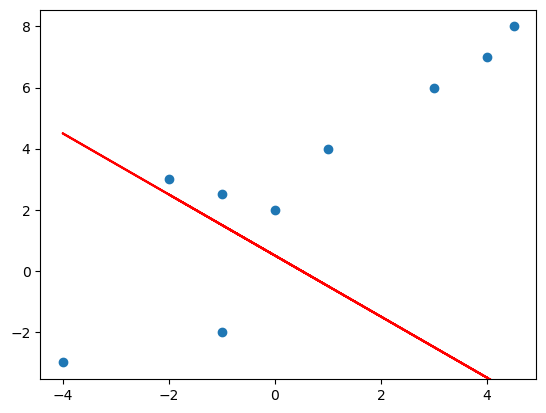

In [56]:
# Aquí tenemos un conjunto simple de 1D de datos de input: una serie de puntos x, cada uno de ellos es una lista de longitud 1
# con respuesta y correspondiente
X_1D = [[1], [-2], [3], [4.5], [0], [-4], [-1], [4], [-1]]
Y_1D = [4,   3,    6,   8,     2,   -3,   -2,   7,   2.5]

# Esta función nos permitirá visualizar un conjunto de datos de 1D,
# pero no necesita entender este paso todavía
def plot_dataset_1D(x, y):
    x_np = np.array(x)
    y_np = np.array(y)
    plt.scatter(x_np[...,0], y_np)

# Esta función nos permitirá visualizar el ajuste de 1D
def plot_fit_1D(X, w, w_0):
    ylim = plt.ylim()
    x_np = np.array(X)
    y_pred = np.array([single_neuron_regression_model(w, w_0, [x]) for x in X])
    plt.plot(x_np[...,0], y_pred, color="red")
    plt.ylim(ylim)
    
# Visualizar el conjunto de datos de arriba
plot_dataset_1D(X_1D, Y_1D)
plot_fit_1D(X_1D, np.array([-1]), 0.5)

epoch 0 has total loss [181.81932812]
epoch 1 has total loss [58.21117846]
epoch 2 has total loss [29.06564973]
epoch 3 has total loss [21.33362308]
epoch 4 has total loss [18.60120782]
epoch 5 has total loss [17.15355854]
epoch 6 has total loss [16.13002322]
epoch 7 has total loss [15.31531374]
epoch 8 has total loss [14.64275285]
epoch 9 has total loss [14.08199098]

Final weights:
[1.25186198] [1.71715378]
Our model has mean square error of [1.47548175]


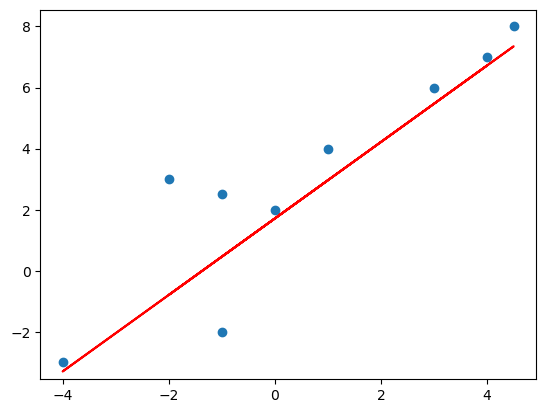

In [68]:
# En este ejemplo, establecemos valores relativamente bajos
# para los pesos y la tasa de aprendizaje
w_0 = np.random.randn(1)
w = np.random.randn(1)
learning_rate = 0.01
epochs = 10
   
w, w_0 = train_model_SE_loss(single_neuron_regression_model, w, w_0, 
                             X_1D, Y_1D, 
                             learning_rate, epochs)
print("\nFinal weights:")
print(w, w_0)
evaluate_regression_accuracy(single_neuron_regression_model, w, w_0, X_1D, Y_1D)

plot_dataset_1D(X_1D, Y_1D)
plot_fit_1D(X_1D, w, w_0)

# Modelo de clasificación con una sola neurona

Para el problema de clasificación, solo tenemos que implementar unos cuantos cambios. En primer lugar, cambiamos la función de activación por una sigmoide. Esto reduce la preactivación $z$ a una activación (*output*) con un valor entre 0 y 1. También tenemos que implementar el cálculo de gradiente con esta función de activación sigmoide.

Por último, para el problema de clasificación, utilizaremos una función de pérdida diferente: la pérdida de log-verosimilitud negativa (NLL). Esto permitirá que nuestro código de entrenamiento anterior siga funcionando, pero aplicado a un problema de clasificación en vez de a uno de regresión.

### Descenso de gradiente con pérdida de log-verosimilitud negativa (NLL)

En el caso de la pérdida de NLL, para cualquier punto de datos de muestra $i$, el gradientede $J$ respecto a los pesos será:

$$ \frac{dJ}{dw_j} = \frac{dL_{NLL}}{dw_j}  
  = \frac{dL_{NLL}}{d\hat{y}} \frac{d\hat{y}}{dw_j}  
  = \frac{dL_{NLL}}{d\hat{y}} \frac{d\hat{y}}{dz} \frac{dz}{dw_j} 
  = \frac{dL_{NLL}}{d\hat{y}} \frac{d\sigma{(z)}}{dz} \frac{dz}{dw_j} .
 $$

Para el primer término, volveremos a llamar la definición $L_{NLL} = y \log{\hat{y}} + (1-y)\log{(1-\hat{y})}$, lo que nos da el siguiente resultado:

$$ \frac{dL_{NLL}}{d\hat{y}} = \frac{y-\hat{y}}{\hat{y}(1-\hat{y})} .$$

Para el segundo, la derivada de la función de activación $\sigma(z)$, obtenemos:

$$ \frac{d\sigma{(z)}}{dz} = \sigma(z)(1-\sigma(z)  = \hat{y}(1-\hat{y}).$$

El último término es simplemente $\frac{dz}{dw_j} = x$, salvo por $\frac{dz}{dw_0} = 1$.


In [69]:
def single_neuron_classification_model(w, w_0, x):
    # Ejecutar el producto escalar del input x y los pesos aprendidos w
    z = x @ w.T + w_0
    
    # Aplicar la función de activación y devolver
    a = sigmoid(z) #ESTE ES EL ÚNICO CAMBIO
    return a

# Función de activación sigmoide; reduce un valor real z al rango entre 0 y 1
def sigmoid(z):
    non_zero_tolerance = 1e-8 # Añadir esto a las divisiones para garantizar que no dividimos entre 0
    return 1 / (1 + math.exp(-z) + non_zero_tolerance)

<function matplotlib.pyplot.show(close=None, block=None)>

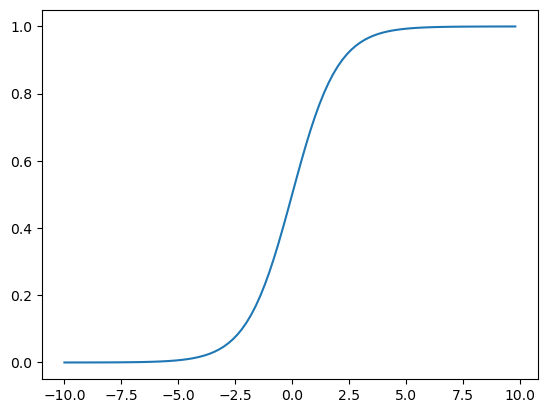

In [70]:
# Vamos a visualizar la siguiente función sigmoide:
sig_x = np.arange(-10, 10, .2)
sig_y = [sigmoid(x) for x in sig_x]
plt.plot(sig_x, sig_y)
plt.show

In [71]:
# Proceso de entrenamiento, usando la pérdida de log-verosimilitud negativa (NLL),
# adecuado para problemas de clasificación

def train_model_NLL_loss(model_function, w, w_0, 
                         input_data, output_data, 
                         learning_rate, num_epochs):
    non_zero_tolerance = 1e-8 # Añadir esto a los cálculos de log para asegurarnos de no tomar log de 0
    do_print = False
    for epoch in range(num_epochs):
        total_loss = 0 # Hacer el seguimiento de la pérdida total en todo el conjunto de datos
        for x, y in zip(input_data, output_data):
            y_predicted = model_function(w, w_0, x)
            nll_loss = -(y * math.log(y_predicted + non_zero_tolerance) + (1-y) * math.log(1-y_predicted + non_zero_tolerance))
            
            total_loss += nll_loss
            if do_print: print("x:", x, "y:", y, "nll_loss:", nll_loss)
            if do_print: print(" old weights:", w, w_0)

            # Actualizar el coeficiente del sesgo con el gradiente respecto a w_0
            w_0 -= learning_rate * (y_predicted - y)
            
            # Actualizar otros coeficientes del modelo con el gradiente respecto a cada coeficiente
            for j, x_j in enumerate(x):
                w[j] -= learning_rate * (y_predicted - y) * x_j
                
            if do_print: print(" new weights:", w, w_0)
            
        report_every = max(1, num_epochs // 10)
        if epoch % report_every == 0: # Cada pocos ciclos, generar un informe
            print("epoch", epoch, "has total loss", total_loss)
           
    return w, w_0

In [72]:
# Utilizaremos esta función para evaluar el rendimiento de nuestro clasificador entrenado
def evaluate_classification_accuracy(model_function, w, w_0, input_data, labels):
    # Contar el número de muestras clasificadas correctamente dado un conjunto de pesos
    correct = 0
    n = len(input_data)
    for x, y in zip(input_data, labels):
        y_predicted = model_function(w, w_0, x)
        label_predicted = 1 if y_predicted > 0.5 else 0
        if label_predicted == y:
            correct += 1
        else:
            print("Misclassify", x, y, "with activation", y_predicted)
    accuracy = correct / n
    print("Our model predicted", correct, "out of", n, 
          "correctly for", accuracy*100, "% accuracy")
    return accuracy

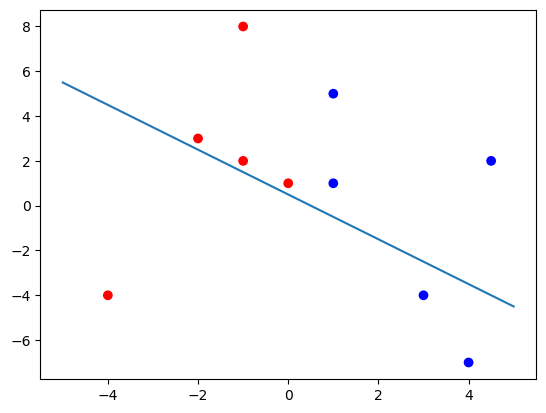

In [77]:
# Aquí tenemos un conjunto de datos compuesto por puntos de datos en 2D linealmente separables
input_data = [[1, 1],
              [1, 5],
              [-2, 3],
              [3, -4],
              [4.5, 2],
              [0, 1],
              [-4, -4],
              [-1, 2],
              [4, -7],
              [-1, 8]]
# Y sus etiquetas correspondientes
labels = [1, 1, 0, 1, 1, 0, 0, 0, 1, 0]

# Esta función nos permitirá visualizar un conjunto de datos de 2D,
# pero no necesita entender este paso todavía
def plot_dataset_2D(x, y):
    x_np = np.array(x)
    x_np.reshape(len(x), 2)
    colors = []
    for label in y:
        if label == 0:
            colors.append("red")
        else:
            colors.append("blue")
    plt.scatter(x_np[...,0], x_np[...,1], color=colors)

# Esta función nos permitirá visualizar una frontera de decisión de 2D
def plot_decision_boundary_2D(w, w_0):
    ylim = plt.ylim()
    x1 = np.arange(-5,6)
    plt.plot(x1, (-w_0 - w[0]*x1)/w[1])
    plt.ylim(ylim)
    
# Visualizar el conjunto de datos que aparece arriba
plot_dataset_2D(input_data, labels)
plot_decision_boundary_2D([1, 1.0001], -0.5)


A partir de este gráfico, vemos que el conjunto de datos es separable linealmente, lo que significa que podemos separar las muestras positivas (azules) de las negativas (rojas) con una sola línea.

## Entrenar pesos reales -- Clasificador de una sola neurona

Ahora que tenemos el conjunto de datos, queremos entrenar el modelo de clasificación de una sola neurona para que encuentre un conjunto de pesos que prediga adecuadamente los datos. Para ello, tenemos tres elementos con los que jugar: los pesos iniciales, la tasa de aprendizaje y el número de ciclos. En los siguientes ejemplos, veremos la influencia que ejerce cada uno de ellos en la capacidad del modelo de converger en una frontera de decisión precisa.

Como regla general, nos interesa que la tasa de aprendizaje sea pequeña en comparación con los valores de los datos de *input*, que los pesos iniciales sean relativamente pequeños (a menudo inicializados al azar) y que el número de ciclos sea relativamente grande. Se ha investigado mucho sobre cómo definir los valores ideales para estos parámetros y esta explicación es una simplificación muy básica.

epoch 0 has total loss 31.413825113564535
epoch 1 has total loss 24.49702259592125
epoch 2 has total loss 17.94116081139832
epoch 3 has total loss 12.074104560246202
epoch 4 has total loss 7.490431731062645
epoch 5 has total loss 4.760225690301513
epoch 6 has total loss 3.5331115531396535
epoch 7 has total loss 3.0021693128620655
epoch 8 has total loss 2.739301406980989
epoch 9 has total loss 2.5869028402306786
epoch 10 has total loss 2.485511484688082

Final weights:
[0.82678385 0.00482861] [-0.52069448]
Our model predicted 10 out of 10 correctly for 100.0 % accuracy


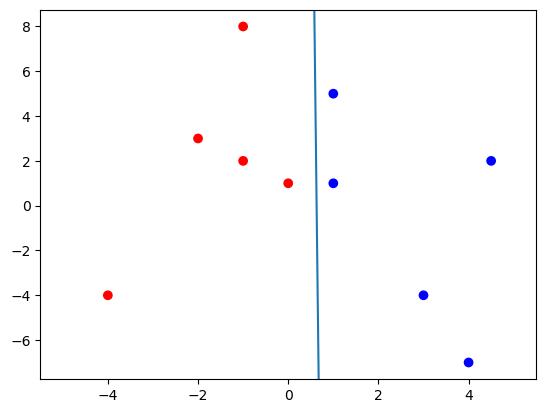

In [78]:
# En este ejemplo, establecemos valores relativamente bajos
# para los pesos y la tasa de aprendizaje. Sin embargo, solo entrenamos durante unos cuantos ciclos,
# lo que no resulta suficiente para converger en un clasificador adecuado
w_0 = np.random.randn(1)
w = np.random.randn(2)

learning_rate = 0.01
epochs = 11

w, w_0 = train_model_NLL_loss(single_neuron_classification_model, w, w_0,
                              input_data, labels, 
                              learning_rate, epochs)
print("\nFinal weights:")
print(w, w_0)
evaluate_classification_accuracy(single_neuron_classification_model, w, w_0, input_data, labels)
plot_dataset_2D(input_data, labels)
plot_decision_boundary_2D(w, w_0)

epoch 0 has total loss 6.223923692215003
epoch 11 has total loss 2.845413147188406
epoch 22 has total loss 2.286683662048281
epoch 33 has total loss 1.9980496255183593
epoch 44 has total loss 1.8078256447161818
epoch 55 has total loss 1.667523921291107
epoch 66 has total loss 1.5572240073027859
epoch 77 has total loss 1.4668866159745202
epoch 88 has total loss 1.3907563310095117
epoch 99 has total loss 1.3252295509074399

Final weights:
[1.763752257216463, -0.08686008420751494] -0.15574330509587198
Our model predicted 10 out of 10 correctly for 100.0 % accuracy


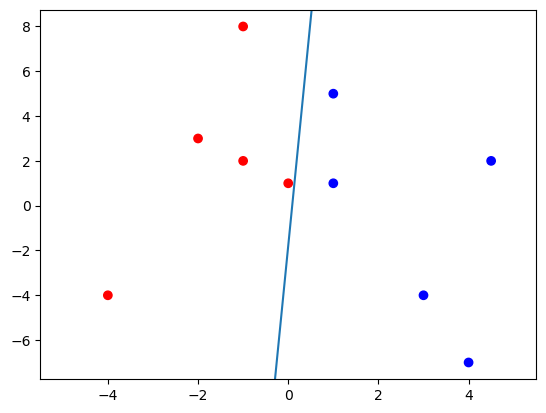

In [17]:
# Por lo general, no conviene inicializar todos los pesos en 0
# Aquí, utilizaremos valores bajos que no sean 0,
# y entrenaremos durante más ciclos
w_0 = 0.1
w = [0.1, 0.1]

# En la práctica, los pesos se suelen inicializar de forma aleatoria, p. ej.:
# con valores normales (Gaussianos), lo que funciona bien si los datos
# de input se han normalizado (aunque no es el caso de nuestros datos)

# También puede probar las siguientes opciones, quitándoles el formato de comentario:
## w_0 = random.gauss(0,1)
## w = [random.gauss(0,1) for i in range(2)]

learning_rate = 0.01
epochs = 110

w, w_0 = train_model_NLL_loss(single_neuron_classification_model, w, w_0,
                              input_data, labels, 
                              learning_rate, epochs)
print("\nFinal weights:")
print(w, w_0)
evaluate_classification_accuracy(single_neuron_classification_model, w, w_0, input_data, labels)
plot_dataset_2D(input_data, labels)
plot_decision_boundary_2D(w, w_0)

## Práctica: Conjunto de datos en 3D

Ahora que hemos implementado el clasificador de una sola neurona en un conjunto de datos en 2D, es hora de pasar a la práctica. Le proporcionaremos un conjunto de datos de 3D y deberá usarlo para entrenar un clasificador de una sola neurona:

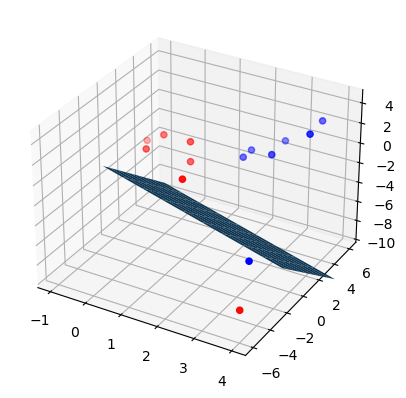

In [18]:
# Abajo aparece un conjunto de datos de 3D de muestras binarias etiquetadas. Debería poder utilizar
# las funciones ya existentes para entrenar un perceptrón que clasifique perfectamente
# el conjunto de datos con un plano de decisión
input_data = [
     [1,1,1],
     [1,1,-1],
     [-1,4,-3],
     [2,4,-1],
     [3.5,6,2],
     [4,-6,-7],
     [2,-4,2],
     [4,-5,-3],
     [0,2,0],
     [3,2,1],
     [4,2,4],
     [2.5,6,-1],
     [0,0,0],
     [2,3,-1]]
labels = [0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1]

# Esta función nos permitirá mostrar el conjunto de datos en un gráfico en 3D,
# pero no necesita entender este paso todavía
def plot_3d_dataset(x, y): 
    x_np_3d = np.array(x)
    x_np_3d.reshape(len(x),3)
    colors = []
    for label in y:
        if label == 0:
            colors.append("red")
        else:
            colors.append("blue")
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(x_np_3d[...,0], x_np_3d[...,1],x_np_3d[...,2], color = colors)
    return ax

# Esta función nos permitirá reproducir en un gráfico la frontera de decisión de 3D
# para un conjunto de pesos dado
def plot_3d_decision_boundary(ax, w, w_0):
  x = np.linspace(-1,4,10)
  y = np.linspace(-1,6,10)
  X,Y = np.meshgrid(x,y)
  Z = (-X*w[0] - Y*w[1] - w_0)/w[2]
  surf = ax.plot_surface(X, Y, Z)
  ax.set_zlim(-10,5)
  return
ax = plot_3d_dataset(input_data, labels)
plot_3d_decision_boundary(ax, [1,1,1], 4)

In [19]:
# PRÁCTICA: Complete el siguiente código para hallar un conjunto de pesos
# que clasifique el conjunto de datos con una precisión del 90 % o superior:
w_0 = ...
w = ...

# ESCRIBA AQUÍ SU CÓDIGO

# print("\nFinal weights:")
# print(w, w_0)
# evaluate_classification_accuracy(...)
# ax = plot_3d_dataset(input_data, labels)
# plot_3d_decision_boundary(ax, w, w_0)

## Solución al ejemplo del conjunto de datos en 3D

epoch 0 has total loss 8.363485666615288
epoch 10 has total loss 7.129679198130538
epoch 20 has total loss 6.513824362841735
epoch 30 has total loss 6.013497796393884
epoch 40 has total loss 5.588910141366436
epoch 50 has total loss 5.224544288901733
epoch 60 has total loss 4.909687253968319
epoch 70 has total loss 4.635809135238037
epoch 80 has total loss 4.395976969470983
epoch 90 has total loss 4.1845562286780265
epoch 100 has total loss 3.9969710083658487

Final weights:
[1.052996389310848, 0.3737356267223445, 0.18169076458208044] -1.5713639671880502
Misclassify [1, 1, 1] 0 with activation 0.5092636405978489
Our model predicted 13 out of 14 correctly for 92.85714285714286 % accuracy


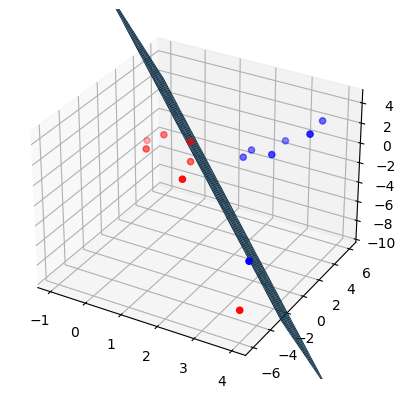

In [20]:
w_0 = 0.1
w = [0.1, 0.1, 0.1]

#random.seed(123)
#w_0 = random.gauss(0,1)
#w = [random.gauss(0,1) for i in range(3)]

learning_rate = 0.01
epochs = 101

w, w_0 = train_model_NLL_loss(single_neuron_classification_model, w, w_0, 
                              input_data, labels, 
                              learning_rate, epochs)
print("\nFinal weights:")
print(w, w_0)
evaluate_classification_accuracy(single_neuron_classification_model, w, w_0, input_data, labels)
ax = plot_3d_dataset(input_data, labels)
plot_3d_decision_boundary(ax, w, w_0)